In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
fake_news = pd.read_csv("train.csv")

In [2]:
# Generate Term Frequency Matrix
from sklearn.feature_extraction.text import CountVectorizer
def create_term_matrix(messages, n_features=50):
    count_vect = CountVectorizer(stop_words='english',max_features = n_features)
    X_counts = count_vect.fit_transform(messages)
    X_term_matrix = pd.DataFrame(X_counts.toarray(), columns=[count_vect.get_feature_names()])
    return X_term_matrix

In [3]:
# Generate tfidf Matrix
from sklearn.feature_extraction.text import TfidfTransformer
def create_tfidf_matrix(messages, n_features=50):
    count_vect = CountVectorizer(stop_words='english',max_features = n_features)
    X_counts = count_vect.fit_transform(messages)
    tf_transformer = TfidfTransformer().fit(X_counts)
    X_tfidf = tf_transformer.transform(X_counts)
    X_tfidf_matrix = pd.DataFrame(X_tfidf.toarray(), columns=[count_vect.get_feature_names()])
    return X_tfidf_matrix

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
def process_sentence(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b') # Align with tokenize method when creating term matrix
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stopwords.words('english')]
    return filtered_words

#### Similarity Score ---- similarity among the scraped titles

In [5]:
def similarity_score(headline_index):
    df = pd.read_csv("Google_Scraped/title_scraped_"+str(headline_index)+".csv").dropna()
    if df.shape[0]>0:
        term_matrix = create_term_matrix(df["searched"])
#         query = fake_news["Statement"][headline_index]
#         orig_terms = list(set(process_sentence(query))&set(item[0] for item in term_matrix.columns))
#         orig_terms = list(set(process_sentence(query)))
#         term_matrix = term_matrix.loc[:,orig_terms].fillna(0)
        try:
            score = sum(term_matrix.sum()/term_matrix.shape[0])
        except:
            score = 0
    else:
        score = 0
    return score

#### How many titles been scraped

In [6]:
# Number of scrap
def number_of_scrap(headline_index):
    df = pd.read_csv("Google_Scraped/title_scraped_"+str(headline_index)+".csv").dropna()
    return df.shape[0]

#### How many terms in original statement, also appears in scraped titles

In [7]:
# Number of words in common
def num_common_term(headline_index):
    df = pd.read_csv("Google_Scraped/title_scraped_"+str(headline_index)+".csv").dropna()
    if df.shape[0]>0:
        term_matrix = create_term_matrix(df["searched"])
        query = fake_news["Statement"][headline_index]
        num_term_common = len((set(process_sentence(query))&set(item[0] for item in term_matrix.columns)))
    else:
        num_term_common = 0
    return num_term_common

#### How many trusted sources appears in title

In [8]:
# Has Critical Word i.e., CNN/BBC etc.
def critical_word(headline_index):
    df = pd.read_csv("Google_Scraped/title_scraped_"+str(headline_index)+".csv").dropna()
    all_titles = " ".join(df["searched"])
    critical_word_count = 0
    if "CNN" in all_titles:
        critical_word_count += 1
    if "BBC" in all_titles:
        critical_word_count += 1
    if "The New York Times" in all_titles:
        critical_word_count += 1
    if "Fox News" in all_titles:
        critical_word_count += 1
    if "POLITICO" in all_titles:
        critical_word_count += 1
    if "NBC" in all_titles:
        critical_word_count += 1
    if "Bloomberg" in all_titles:
        critical_word_count += 1
    if "PolitiFact" in all_titles:
        critical_word_count += 1

    return critical_word_count

#### How many scraped titles similar to the original headline

In [9]:
from nltk.stem.porter import PorterStemmer

def stem_tokens(tokens,stemmer):
    return [stemmer.stem(item) for item in tokens]

def process_sentence_stem(sentence,stemmer=PorterStemmer()):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stopwords.words('english')]
    return stem_tokens(filtered_words,stemmer)

In [10]:
def similarity_sentence(sentence1, sentence2):
    sen1 = process_sentence_stem(sentence1)
    sen2 = process_sentence_stem(sentence2)
    common = set(sen1)&set(sen2)
    return len(common)/len(sen1)

In [11]:
def similar_title_count(headline_index):
    df = pd.read_csv("Google_Scraped/title_scraped_"+str(headline_index)+".csv").dropna()
    similar_sentence_count = 0
    for title in df["searched"]:
        if similarity_sentence(fake_news.loc[headline_index,"Statement"], title) >= 0.2:
            similar_sentence_count += 1
    return similar_sentence_count

#### how many url from trusted sources

In [19]:
import numpy as np
from urllib.parse import urlparse
def trusted_url(headline_index):
    df = pd.read_csv("URL_Scraped/url_scraped_"+str(headline_index)+".csv").dropna()
    if df.shape[0]>0:    
        for index, row in df.iterrows():
            parsed_uri = urlparse(row["searched_url"])
            domain_name = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
            trusted_src = any(word in domain_name for word in ["politifact","cnn","bbc","bloomberg","nytimes"])
            df.set_value(index,'domain',domain_name)
            df.set_value(index,'trusted_src',trusted_src)
            cnt_trst_src = sum(np.array(df["trusted_src"])*(np.array(range(df.shape[0]))+1)[::-1])
        return cnt_trst_src
    else:
        return 0

In [23]:
# Append score to dataframe for each headlines
for index, row in fake_news.iterrows():
    print("calculating:", index)
    fake_news.set_value(index,'score',similarity_score(index))
    fake_news.set_value(index,'num_scrap',number_of_scrap(index))
    fake_news.set_value(index,'common_term',num_common_term(index))
    fake_news.set_value(index,'crit_term',critical_word(index))
    fake_news.set_value(index,'similar_cnt',similar_title_count(index))
    fake_news.set_value(index,'url_score',trusted_url(index))
fake_news

calculating: 0
calculating: 1
calculating: 2
calculating: 3
calculating: 4
calculating: 5
calculating: 6
calculating: 7
calculating: 8
calculating: 9
calculating: 10
calculating: 11
calculating: 12
calculating: 13
calculating: 14
calculating: 15
calculating: 16
calculating: 17
calculating: 18
calculating: 19
calculating: 20
calculating: 21
calculating: 22
calculating: 23
calculating: 24
calculating: 25
calculating: 26
calculating: 27
calculating: 28
calculating: 29
calculating: 30
calculating: 31
calculating: 32
calculating: 33
calculating: 34
calculating: 35
calculating: 36
calculating: 37
calculating: 38
calculating: 39
calculating: 40
calculating: 41
calculating: 42
calculating: 43
calculating: 44
calculating: 45
calculating: 46
calculating: 47
calculating: 48
calculating: 49
calculating: 50
calculating: 51
calculating: 52
calculating: 53
calculating: 54
calculating: 55
calculating: 56
calculating: 57
calculating: 58
calculating: 59
calculating: 60
calculating: 61
calculating: 62
ca

calculating: 490
calculating: 491
calculating: 492
calculating: 493
calculating: 494
calculating: 495
calculating: 496
calculating: 497
calculating: 498
calculating: 499
calculating: 500
calculating: 501
calculating: 502
calculating: 503
calculating: 504
calculating: 505
calculating: 506
calculating: 507
calculating: 508
calculating: 509
calculating: 510
calculating: 511
calculating: 512
calculating: 513
calculating: 514
calculating: 515
calculating: 516
calculating: 517
calculating: 518
calculating: 519
calculating: 520
calculating: 521
calculating: 522
calculating: 523
calculating: 524
calculating: 525
calculating: 526
calculating: 527
calculating: 528
calculating: 529
calculating: 530
calculating: 531
calculating: 532
calculating: 533
calculating: 534
calculating: 535
calculating: 536
calculating: 537
calculating: 538
calculating: 539
calculating: 540
calculating: 541
calculating: 542
calculating: 543
calculating: 544
calculating: 545
calculating: 546
calculating: 547
calculating: 5

calculating: 972
calculating: 973
calculating: 974
calculating: 975
calculating: 976
calculating: 977
calculating: 978
calculating: 979
calculating: 980
calculating: 981
calculating: 982
calculating: 983
calculating: 984
calculating: 985
calculating: 986
calculating: 987
calculating: 988
calculating: 989
calculating: 990
calculating: 991
calculating: 992
calculating: 993
calculating: 994
calculating: 995
calculating: 996
calculating: 997
calculating: 998
calculating: 999
calculating: 1000
calculating: 1001
calculating: 1002
calculating: 1003
calculating: 1004
calculating: 1005
calculating: 1006
calculating: 1007
calculating: 1008
calculating: 1009
calculating: 1010
calculating: 1011
calculating: 1012
calculating: 1013
calculating: 1014
calculating: 1015
calculating: 1016
calculating: 1017
calculating: 1018
calculating: 1019
calculating: 1020
calculating: 1021
calculating: 1022
calculating: 1023
calculating: 1024
calculating: 1025
calculating: 1026
calculating: 1027
calculating: 1028
ca

calculating: 1429
calculating: 1430
calculating: 1431
calculating: 1432
calculating: 1433
calculating: 1434
calculating: 1435
calculating: 1436
calculating: 1437
calculating: 1438
calculating: 1439
calculating: 1440
calculating: 1441
calculating: 1442
calculating: 1443
calculating: 1444
calculating: 1445
calculating: 1446
calculating: 1447
calculating: 1448
calculating: 1449
calculating: 1450
calculating: 1451
calculating: 1452
calculating: 1453
calculating: 1454
calculating: 1455
calculating: 1456
calculating: 1457
calculating: 1458
calculating: 1459
calculating: 1460
calculating: 1461
calculating: 1462
calculating: 1463
calculating: 1464
calculating: 1465
calculating: 1466
calculating: 1467
calculating: 1468
calculating: 1469
calculating: 1470
calculating: 1471
calculating: 1472
calculating: 1473
calculating: 1474
calculating: 1475
calculating: 1476
calculating: 1477
calculating: 1478
calculating: 1479
calculating: 1480
calculating: 1481
calculating: 1482
calculating: 1483
calculatin

calculating: 1885
calculating: 1886
calculating: 1887
calculating: 1888
calculating: 1889
calculating: 1890
calculating: 1891
calculating: 1892
calculating: 1893
calculating: 1894
calculating: 1895
calculating: 1896
calculating: 1897
calculating: 1898
calculating: 1899
calculating: 1900
calculating: 1901
calculating: 1902
calculating: 1903
calculating: 1904
calculating: 1905
calculating: 1906
calculating: 1907
calculating: 1908
calculating: 1909
calculating: 1910
calculating: 1911
calculating: 1912
calculating: 1913
calculating: 1914
calculating: 1915
calculating: 1916
calculating: 1917
calculating: 1918
calculating: 1919
calculating: 1920
calculating: 1921
calculating: 1922
calculating: 1923
calculating: 1924
calculating: 1925
calculating: 1926
calculating: 1927
calculating: 1928
calculating: 1929
calculating: 1930
calculating: 1931
calculating: 1932
calculating: 1933
calculating: 1934
calculating: 1935
calculating: 1936
calculating: 1937
calculating: 1938
calculating: 1939
calculatin

calculating: 2341
calculating: 2342
calculating: 2343
calculating: 2344
calculating: 2345
calculating: 2346
calculating: 2347
calculating: 2348
calculating: 2349
calculating: 2350
calculating: 2351
calculating: 2352
calculating: 2353
calculating: 2354
calculating: 2355
calculating: 2356
calculating: 2357
calculating: 2358
calculating: 2359
calculating: 2360
calculating: 2361
calculating: 2362
calculating: 2363
calculating: 2364
calculating: 2365
calculating: 2366
calculating: 2367
calculating: 2368
calculating: 2369
calculating: 2370
calculating: 2371
calculating: 2372
calculating: 2373
calculating: 2374
calculating: 2375
calculating: 2376
calculating: 2377
calculating: 2378
calculating: 2379
calculating: 2380
calculating: 2381
calculating: 2382
calculating: 2383
calculating: 2384
calculating: 2385
calculating: 2386
calculating: 2387
calculating: 2388
calculating: 2389
calculating: 2390
calculating: 2391
calculating: 2392
calculating: 2393
calculating: 2394
calculating: 2395
calculatin

calculating: 2797
calculating: 2798
calculating: 2799
calculating: 2800
calculating: 2801
calculating: 2802
calculating: 2803
calculating: 2804
calculating: 2805
calculating: 2806
calculating: 2807
calculating: 2808
calculating: 2809
calculating: 2810
calculating: 2811
calculating: 2812
calculating: 2813
calculating: 2814
calculating: 2815
calculating: 2816
calculating: 2817
calculating: 2818
calculating: 2819
calculating: 2820
calculating: 2821
calculating: 2822
calculating: 2823
calculating: 2824
calculating: 2825
calculating: 2826
calculating: 2827
calculating: 2828
calculating: 2829
calculating: 2830
calculating: 2831
calculating: 2832
calculating: 2833
calculating: 2834
calculating: 2835
calculating: 2836
calculating: 2837
calculating: 2838
calculating: 2839
calculating: 2840
calculating: 2841
calculating: 2842
calculating: 2843
calculating: 2844
calculating: 2845
calculating: 2846
calculating: 2847
calculating: 2848
calculating: 2849
calculating: 2850
calculating: 2851
calculatin

calculating: 3254
calculating: 3255
calculating: 3256
calculating: 3257
calculating: 3258
calculating: 3259
calculating: 3260
calculating: 3261
calculating: 3262
calculating: 3263
calculating: 3264
calculating: 3265
calculating: 3266
calculating: 3267
calculating: 3268
calculating: 3269
calculating: 3270
calculating: 3271
calculating: 3272
calculating: 3273
calculating: 3274
calculating: 3275
calculating: 3276
calculating: 3277
calculating: 3278
calculating: 3279
calculating: 3280
calculating: 3281
calculating: 3282
calculating: 3283
calculating: 3284
calculating: 3285
calculating: 3286
calculating: 3287
calculating: 3288
calculating: 3289
calculating: 3290
calculating: 3291
calculating: 3292
calculating: 3293
calculating: 3294
calculating: 3295
calculating: 3296
calculating: 3297
calculating: 3298
calculating: 3299
calculating: 3300
calculating: 3301
calculating: 3302
calculating: 3303
calculating: 3304
calculating: 3305
calculating: 3306
calculating: 3307
calculating: 3308
calculatin

calculating: 3711
calculating: 3712
calculating: 3713
calculating: 3714
calculating: 3715
calculating: 3716
calculating: 3717
calculating: 3718
calculating: 3719
calculating: 3720
calculating: 3721
calculating: 3722
calculating: 3723
calculating: 3724
calculating: 3725
calculating: 3726
calculating: 3727
calculating: 3728
calculating: 3729
calculating: 3730
calculating: 3731
calculating: 3732
calculating: 3733
calculating: 3734
calculating: 3735
calculating: 3736
calculating: 3737
calculating: 3738
calculating: 3739
calculating: 3740
calculating: 3741
calculating: 3742
calculating: 3743
calculating: 3744
calculating: 3745
calculating: 3746
calculating: 3747
calculating: 3748
calculating: 3749
calculating: 3750
calculating: 3751
calculating: 3752
calculating: 3753
calculating: 3754
calculating: 3755
calculating: 3756
calculating: 3757
calculating: 3758
calculating: 3759
calculating: 3760
calculating: 3761
calculating: 3762
calculating: 3763
calculating: 3764
calculating: 3765
calculatin

calculating: 4168
calculating: 4169
calculating: 4170
calculating: 4171
calculating: 4172
calculating: 4173
calculating: 4174
calculating: 4175
calculating: 4176
calculating: 4177
calculating: 4178
calculating: 4179
calculating: 4180
calculating: 4181
calculating: 4182
calculating: 4183
calculating: 4184
calculating: 4185
calculating: 4186
calculating: 4187
calculating: 4188
calculating: 4189
calculating: 4190
calculating: 4191
calculating: 4192
calculating: 4193
calculating: 4194
calculating: 4195
calculating: 4196
calculating: 4197
calculating: 4198
calculating: 4199
calculating: 4200
calculating: 4201
calculating: 4202
calculating: 4203
calculating: 4204
calculating: 4205
calculating: 4206
calculating: 4207
calculating: 4208
calculating: 4209
calculating: 4210
calculating: 4211
calculating: 4212
calculating: 4213
calculating: 4214
calculating: 4215
calculating: 4216
calculating: 4217
calculating: 4218
calculating: 4219
calculating: 4220
calculating: 4221
calculating: 4222
calculatin

calculating: 4625
calculating: 4626
calculating: 4627
calculating: 4628
calculating: 4629
calculating: 4630
calculating: 4631
calculating: 4632
calculating: 4633
calculating: 4634
calculating: 4635
calculating: 4636
calculating: 4637
calculating: 4638
calculating: 4639
calculating: 4640
calculating: 4641
calculating: 4642
calculating: 4643
calculating: 4644
calculating: 4645
calculating: 4646
calculating: 4647
calculating: 4648
calculating: 4649
calculating: 4650
calculating: 4651
calculating: 4652
calculating: 4653
calculating: 4654
calculating: 4655
calculating: 4656
calculating: 4657
calculating: 4658
calculating: 4659
calculating: 4660
calculating: 4661
calculating: 4662
calculating: 4663
calculating: 4664
calculating: 4665
calculating: 4666
calculating: 4667
calculating: 4668
calculating: 4669
calculating: 4670
calculating: 4671
calculating: 4672
calculating: 4673
calculating: 4674
calculating: 4675
calculating: 4676
calculating: 4677
calculating: 4678
calculating: 4679
calculatin

calculating: 5082
calculating: 5083
calculating: 5084
calculating: 5085
calculating: 5086
calculating: 5087
calculating: 5088
calculating: 5089
calculating: 5090
calculating: 5091
calculating: 5092
calculating: 5093
calculating: 5094
calculating: 5095
calculating: 5096
calculating: 5097
calculating: 5098
calculating: 5099
calculating: 5100
calculating: 5101
calculating: 5102
calculating: 5103
calculating: 5104
calculating: 5105
calculating: 5106
calculating: 5107
calculating: 5108
calculating: 5109
calculating: 5110
calculating: 5111
calculating: 5112
calculating: 5113
calculating: 5114
calculating: 5115
calculating: 5116
calculating: 5117
calculating: 5118
calculating: 5119
calculating: 5120
calculating: 5121
calculating: 5122
calculating: 5123
calculating: 5124
calculating: 5125
calculating: 5126
calculating: 5127
calculating: 5128
calculating: 5129
calculating: 5130
calculating: 5131
calculating: 5132
calculating: 5133
calculating: 5134
calculating: 5135
calculating: 5136
calculatin

calculating: 5539
calculating: 5540
calculating: 5541
calculating: 5542
calculating: 5543
calculating: 5544
calculating: 5545
calculating: 5546
calculating: 5547
calculating: 5548
calculating: 5549
calculating: 5550
calculating: 5551
calculating: 5552
calculating: 5553
calculating: 5554
calculating: 5555
calculating: 5556
calculating: 5557
calculating: 5558
calculating: 5559
calculating: 5560
calculating: 5561
calculating: 5562
calculating: 5563
calculating: 5564
calculating: 5565
calculating: 5566
calculating: 5567
calculating: 5568
calculating: 5569
calculating: 5570
calculating: 5571
calculating: 5572
calculating: 5573
calculating: 5574
calculating: 5575
calculating: 5576
calculating: 5577
calculating: 5578
calculating: 5579
calculating: 5580
calculating: 5581
calculating: 5582
calculating: 5583
calculating: 5584
calculating: 5585
calculating: 5586
calculating: 5587
calculating: 5588
calculating: 5589
calculating: 5590
calculating: 5591
calculating: 5592
calculating: 5593
calculatin

calculating: 5996
calculating: 5997
calculating: 5998
calculating: 5999
calculating: 6000
calculating: 6001
calculating: 6002
calculating: 6003
calculating: 6004
calculating: 6005
calculating: 6006
calculating: 6007
calculating: 6008
calculating: 6009
calculating: 6010
calculating: 6011
calculating: 6012
calculating: 6013
calculating: 6014
calculating: 6015
calculating: 6016
calculating: 6017
calculating: 6018
calculating: 6019
calculating: 6020
calculating: 6021
calculating: 6022
calculating: 6023
calculating: 6024
calculating: 6025
calculating: 6026
calculating: 6027
calculating: 6028
calculating: 6029
calculating: 6030
calculating: 6031
calculating: 6032
calculating: 6033
calculating: 6034
calculating: 6035
calculating: 6036
calculating: 6037
calculating: 6038
calculating: 6039
calculating: 6040
calculating: 6041
calculating: 6042
calculating: 6043
calculating: 6044
calculating: 6045
calculating: 6046
calculating: 6047
calculating: 6048
calculating: 6049
calculating: 6050
calculatin

calculating: 6453
calculating: 6454
calculating: 6455
calculating: 6456
calculating: 6457
calculating: 6458
calculating: 6459
calculating: 6460
calculating: 6461
calculating: 6462
calculating: 6463
calculating: 6464
calculating: 6465
calculating: 6466
calculating: 6467
calculating: 6468
calculating: 6469
calculating: 6470
calculating: 6471
calculating: 6472
calculating: 6473
calculating: 6474
calculating: 6475
calculating: 6476
calculating: 6477
calculating: 6478
calculating: 6479
calculating: 6480
calculating: 6481
calculating: 6482
calculating: 6483
calculating: 6484
calculating: 6485
calculating: 6486
calculating: 6487
calculating: 6488
calculating: 6489
calculating: 6490
calculating: 6491
calculating: 6492
calculating: 6493
calculating: 6494
calculating: 6495
calculating: 6496
calculating: 6497
calculating: 6498
calculating: 6499
calculating: 6500
calculating: 6501
calculating: 6502
calculating: 6503
calculating: 6504
calculating: 6505
calculating: 6506
calculating: 6507
calculatin

calculating: 6910
calculating: 6911
calculating: 6912
calculating: 6913
calculating: 6914
calculating: 6915
calculating: 6916
calculating: 6917
calculating: 6918
calculating: 6919
calculating: 6920
calculating: 6921
calculating: 6922
calculating: 6923
calculating: 6924
calculating: 6925
calculating: 6926
calculating: 6927
calculating: 6928
calculating: 6929
calculating: 6930
calculating: 6931
calculating: 6932
calculating: 6933
calculating: 6934
calculating: 6935
calculating: 6936
calculating: 6937
calculating: 6938
calculating: 6939
calculating: 6940
calculating: 6941
calculating: 6942
calculating: 6943
calculating: 6944
calculating: 6945
calculating: 6946
calculating: 6947
calculating: 6948
calculating: 6949
calculating: 6950
calculating: 6951
calculating: 6952
calculating: 6953
calculating: 6954
calculating: 6955
calculating: 6956
calculating: 6957
calculating: 6958
calculating: 6959
calculating: 6960
calculating: 6961
calculating: 6962
calculating: 6963
calculating: 6964
calculatin

calculating: 7367
calculating: 7368
calculating: 7369
calculating: 7370
calculating: 7371
calculating: 7372
calculating: 7373
calculating: 7374
calculating: 7375
calculating: 7376
calculating: 7377
calculating: 7378
calculating: 7379
calculating: 7380
calculating: 7381
calculating: 7382
calculating: 7383
calculating: 7384
calculating: 7385
calculating: 7386
calculating: 7387
calculating: 7388
calculating: 7389
calculating: 7390
calculating: 7391
calculating: 7392
calculating: 7393
calculating: 7394
calculating: 7395
calculating: 7396
calculating: 7397
calculating: 7398
calculating: 7399
calculating: 7400
calculating: 7401
calculating: 7402
calculating: 7403
calculating: 7404
calculating: 7405
calculating: 7406
calculating: 7407
calculating: 7408
calculating: 7409
calculating: 7410
calculating: 7411
calculating: 7412
calculating: 7413
calculating: 7414
calculating: 7415
calculating: 7416
calculating: 7417
calculating: 7418
calculating: 7419
calculating: 7420
calculating: 7421
calculatin

calculating: 7823
calculating: 7824
calculating: 7825
calculating: 7826
calculating: 7827
calculating: 7828
calculating: 7829
calculating: 7830
calculating: 7831
calculating: 7832
calculating: 7833
calculating: 7834
calculating: 7835
calculating: 7836
calculating: 7837
calculating: 7838
calculating: 7839
calculating: 7840
calculating: 7841
calculating: 7842
calculating: 7843
calculating: 7844
calculating: 7845
calculating: 7846
calculating: 7847
calculating: 7848
calculating: 7849
calculating: 7850
calculating: 7851
calculating: 7852
calculating: 7853
calculating: 7854
calculating: 7855
calculating: 7856
calculating: 7857
calculating: 7858
calculating: 7859
calculating: 7860
calculating: 7861
calculating: 7862
calculating: 7863
calculating: 7864
calculating: 7865
calculating: 7866
calculating: 7867
calculating: 7868
calculating: 7869
calculating: 7870
calculating: 7871
calculating: 7872
calculating: 7873
calculating: 7874
calculating: 7875
calculating: 7876
calculating: 7877
calculatin

calculating: 8280
calculating: 8281
calculating: 8282
calculating: 8283
calculating: 8284
calculating: 8285
calculating: 8286
calculating: 8287
calculating: 8288
calculating: 8289
calculating: 8290
calculating: 8291
calculating: 8292
calculating: 8293
calculating: 8294
calculating: 8295
calculating: 8296
calculating: 8297
calculating: 8298
calculating: 8299
calculating: 8300
calculating: 8301
calculating: 8302
calculating: 8303
calculating: 8304
calculating: 8305
calculating: 8306
calculating: 8307
calculating: 8308
calculating: 8309
calculating: 8310
calculating: 8311
calculating: 8312
calculating: 8313
calculating: 8314
calculating: 8315
calculating: 8316
calculating: 8317
calculating: 8318
calculating: 8319
calculating: 8320
calculating: 8321
calculating: 8322
calculating: 8323
calculating: 8324
calculating: 8325
calculating: 8326
calculating: 8327
calculating: 8328
calculating: 8329
calculating: 8330
calculating: 8331
calculating: 8332
calculating: 8333
calculating: 8334
calculatin

calculating: 8736
calculating: 8737
calculating: 8738
calculating: 8739
calculating: 8740
calculating: 8741
calculating: 8742
calculating: 8743
calculating: 8744
calculating: 8745
calculating: 8746
calculating: 8747
calculating: 8748
calculating: 8749
calculating: 8750
calculating: 8751
calculating: 8752
calculating: 8753
calculating: 8754
calculating: 8755
calculating: 8756
calculating: 8757
calculating: 8758
calculating: 8759
calculating: 8760
calculating: 8761
calculating: 8762
calculating: 8763
calculating: 8764
calculating: 8765
calculating: 8766
calculating: 8767
calculating: 8768
calculating: 8769
calculating: 8770
calculating: 8771
calculating: 8772
calculating: 8773
calculating: 8774
calculating: 8775
calculating: 8776
calculating: 8777
calculating: 8778
calculating: 8779
calculating: 8780
calculating: 8781
calculating: 8782
calculating: 8783
calculating: 8784
calculating: 8785
calculating: 8786
calculating: 8787
calculating: 8788
calculating: 8789
calculating: 8790
calculatin

calculating: 9193
calculating: 9194
calculating: 9195
calculating: 9196
calculating: 9197
calculating: 9198
calculating: 9199
calculating: 9200
calculating: 9201
calculating: 9202
calculating: 9203
calculating: 9204
calculating: 9205
calculating: 9206
calculating: 9207
calculating: 9208
calculating: 9209
calculating: 9210
calculating: 9211
calculating: 9212
calculating: 9213
calculating: 9214
calculating: 9215
calculating: 9216
calculating: 9217
calculating: 9218
calculating: 9219
calculating: 9220
calculating: 9221
calculating: 9222
calculating: 9223
calculating: 9224
calculating: 9225
calculating: 9226
calculating: 9227
calculating: 9228
calculating: 9229
calculating: 9230
calculating: 9231
calculating: 9232
calculating: 9233
calculating: 9234
calculating: 9235
calculating: 9236
calculating: 9237
calculating: 9238
calculating: 9239
calculating: 9240
calculating: 9241
calculating: 9242
calculating: 9243
calculating: 9244
calculating: 9245
calculating: 9246
calculating: 9247
calculatin

calculating: 9650
calculating: 9651
calculating: 9652
calculating: 9653
calculating: 9654
calculating: 9655
calculating: 9656
calculating: 9657
calculating: 9658
calculating: 9659
calculating: 9660
calculating: 9661
calculating: 9662
calculating: 9663
calculating: 9664
calculating: 9665
calculating: 9666
calculating: 9667
calculating: 9668
calculating: 9669
calculating: 9670
calculating: 9671
calculating: 9672
calculating: 9673
calculating: 9674
calculating: 9675
calculating: 9676
calculating: 9677
calculating: 9678
calculating: 9679
calculating: 9680
calculating: 9681
calculating: 9682
calculating: 9683
calculating: 9684
calculating: 9685
calculating: 9686
calculating: 9687
calculating: 9688
calculating: 9689
calculating: 9690
calculating: 9691
calculating: 9692
calculating: 9693
calculating: 9694
calculating: 9695
calculating: 9696
calculating: 9697
calculating: 9698
calculating: 9699
calculating: 9700
calculating: 9701
calculating: 9702
calculating: 9703
calculating: 9704
calculatin

calculating: 10100
calculating: 10101
calculating: 10102
calculating: 10103
calculating: 10104
calculating: 10105
calculating: 10106
calculating: 10107
calculating: 10108
calculating: 10109
calculating: 10110
calculating: 10111
calculating: 10112
calculating: 10113
calculating: 10114
calculating: 10115
calculating: 10116
calculating: 10117
calculating: 10118
calculating: 10119
calculating: 10120
calculating: 10121
calculating: 10122
calculating: 10123
calculating: 10124
calculating: 10125
calculating: 10126
calculating: 10127
calculating: 10128
calculating: 10129
calculating: 10130
calculating: 10131
calculating: 10132
calculating: 10133
calculating: 10134
calculating: 10135
calculating: 10136
calculating: 10137
calculating: 10138
calculating: 10139
calculating: 10140
calculating: 10141
calculating: 10142
calculating: 10143
calculating: 10144
calculating: 10145
calculating: 10146
calculating: 10147
calculating: 10148
calculating: 10149
calculating: 10150
calculating: 10151
calculating:

,Statement,Label,score,num_scrap,common_term,crit_term,similar_cnt,url_score
0,Says the Annies List political group supports ...,False,4.117647,17.0,3.0,1.0,4.0,35.0
1,When did the decline of coal start? It started...,True,3.736842,19.0,2.0,2.0,0.0,10.0
2,"Hillary Clinton agrees with John McCain ""by vo...",True,4.857143,14.0,1.0,0.0,0.0,34.0
3,Health care reform legislation is likely to ma...,False,4.866667,15.0,5.0,1.0,2.0,11.0
4,The economic turnaround started at the end of ...,True,3.571429,21.0,2.0,2.0,10.0,10.0
5,The Chicago Bears have had more starting quart...,True,3.285714,21.0,3.0,1.0,0.0,34.0
6,Jim Dunnam has not lived in the district he re...,False,5.500000,18.0,3.0,0.0,6.0,10.0
7,I'm the only person on this stage who has work...,True,6.000000,10.0,2.0,1.0,0.0,34.0
8,"However, it took $19.5 million in Oregon Lotte...",True,5.000000,14.0,7.0,1.0,4.0,19.0
9,Says GOP primary opponents Glenn Grothman and ...,True,4.875000,8.0,4.0,0.0,0.0,29.0


In [24]:
fake_news.to_csv("fake_news_processed.csv")

#### Train Test Split

In [8]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
fake_news = pd.read_csv("fake_news_processed.csv")
from sklearn.model_selection import train_test_split
X = fake_news.loc[:,["Statement","score","num_scrap","common_term","crit_term","similar_cnt","url_score"]]
y = fake_news.loc[:,"Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8017)

In [9]:
X_train.head()

,Statement,score,num_scrap,common_term,crit_term,similar_cnt,url_score
7490,Says the U.S. national debt has tripled during...,6.700000,10.0,5.0,3.0,8.0,32.0
2556,Says Scott Walker cut taxes for the wealthiest...,4.300000,20.0,4.0,3.0,6.0,27.0
7514,Says you cannot implement Paul Ryans plan with...,4.652174,23.0,4.0,0.0,14.0,10.0
1363,"Under Pat McCrory, (North Carolina) has fallen...",4.842105,19.0,6.0,0.0,8.0,10.0
1847,"Says that Mitt Romney, while he was in Arizona...",4.727273,22.0,5.0,3.0,10.0,19.0


In [11]:
fake_news.loc[:,["Statement","Label","num_scrap","score","common_term","url_score","similar_cnt"]]

,Statement,Label,num_scrap,score,common_term,url_score,similar_cnt
0,Says the Annies List political group supports ...,False,17.0,4.117647,3.0,35.0,4.0
1,When did the decline of coal start? It started...,True,19.0,3.736842,2.0,10.0,0.0
2,"Hillary Clinton agrees with John McCain ""by vo...",True,14.0,4.857143,1.0,34.0,0.0
3,Health care reform legislation is likely to ma...,False,15.0,4.866667,5.0,11.0,2.0
4,The economic turnaround started at the end of ...,True,21.0,3.571429,2.0,10.0,10.0
5,The Chicago Bears have had more starting quart...,True,21.0,3.285714,3.0,34.0,0.0
6,Jim Dunnam has not lived in the district he re...,False,18.0,5.500000,3.0,10.0,6.0
7,I'm the only person on this stage who has work...,True,10.0,6.000000,2.0,34.0,0.0
8,"However, it took $19.5 million in Oregon Lotte...",True,14.0,5.000000,7.0,19.0,4.0
9,Says GOP primary opponents Glenn Grothman and ...,True,8.0,4.875000,4.0,29.0,0.0


#### Exact Match

In [88]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
fake_news = pd.read_csv("fake_news_update.csv", encoding = "ISO-8859-1")

In [89]:
fake_news

,Statement,Label,score,num_scrap,common_term,crit_term,similar_cnt,url_score,exact_match
0,Says the Annies List political group supports ...,False,4.117647,17,3,1,4,35,1.0
1,When did the decline of coal start? It started...,True,3.736842,19,2,2,0,10,5.0
2,"Hillary Clinton agrees with John McCain ""by vo...",True,4.857143,14,1,0,0,34,10.0
3,Health care reform legislation is likely to ma...,False,4.866667,15,5,1,2,11,4.0
4,The economic turnaround started at the end of ...,True,3.571429,21,2,2,10,10,10.0
5,The Chicago Bears have had more starting quart...,True,3.285714,21,3,1,0,34,6.0
6,Jim Dunnam has not lived in the district he re...,False,5.500000,18,3,0,6,10,8.0
7,I'm the only person on this stage who has work...,True,6.000000,10,2,1,0,34,6.0
8,"However, it took $19.5 million in Oregon Lotte...",True,5.000000,14,7,1,4,19,8.0
9,Says GOP primary opponents Glenn Grothman and ...,True,4.875000,8,4,0,0,29,10.0


In [91]:
from googlesearch import search
def google_search(query, top_n):
    url_list = []
    for url in search(query, stop=top_n):
        url_list.append(url)
    return url_list 

In [92]:
def exact_match(index):
    query = "\""+fake_news.loc[index,"Statement"]+"\""
    ext_match_cnt = len(google_search(query, 10))
    return ext_match_cnt

In [120]:
for index in range(520,550):
    print("calculating:", index)
    try:
        fake_news.set_value(index,'exact_match',exact_match(index))
    except Exception as e:
        print("error", e)
        time.sleep(60*20)

calculating: 520
error HTTP Error 429: Too Many Requests


KeyboardInterrupt: 

In [199]:
fake_news.to_csv("fake_news_update.csv", encoding = "utf-8")

In [203]:
fake_news = pd.read_csv("fake_news_update.csv")
fake_news = fake_news.iloc[0:520,:]

In [201]:
from sklearn.model_selection import train_test_split
X = fake_news.loc[:,["score","num_scrap","common_term","crit_term","similar_cnt","url_score","exact_match"]]
y = fake_news.loc[:,"Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8017)

In [205]:
fake_news.loc[:,["Statement", "Label", "num_scrap", "score", "common_term", "url_score", "similar_cnt", "exact_match"]]


,Statement,Label,num_scrap,score,common_term,url_score,similar_cnt,exact_match
0,Says the Annies List political group supports ...,False,17,4.117647,3,35,4,1.0
1,When did the decline of coal start? It started...,True,19,3.736842,2,10,0,5.0
2,"Hillary Clinton agrees with John McCain ""by vo...",True,14,4.857143,1,34,0,10.0
3,Health care reform legislation is likely to ma...,False,15,4.866667,5,11,2,4.0
4,The economic turnaround started at the end of ...,True,21,3.571429,2,10,10,10.0
5,The Chicago Bears have had more starting quart...,True,21,3.285714,3,34,0,6.0
6,Jim Dunnam has not lived in the district he re...,False,18,5.500000,3,10,6,8.0
7,I'm the only person on this stage who has work...,True,10,6.000000,2,34,0,6.0
8,"However, it took $19.5 million in Oregon Lotte...",True,14,5.000000,7,19,4,8.0
9,Says GOP primary opponents Glenn Grothman and ...,True,8,4.875000,4,29,0,10.0


#### Logistic Regression

In [192]:
from sklearn.linear_model import LogisticRegression
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)
pred = logreg_classifier.predict(X_test)

In [193]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_test, pred)

array([[ 3, 12],
       [ 4, 26]])

In [194]:
accuracy_score(y_test, pred)

0.6444444444444445

In [146]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, pred, average = "binary")

(0.6229508196721312, 0.7755102040816326, 0.6909090909090909, None)

#### Random Forest

In [195]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 100, max_depth = 3)
rf_classifier.fit(X_train, y_train)
pred = rf_classifier.predict(X_test)

In [196]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_test, pred)

array([[ 3, 12],
       [ 1, 29]])

In [197]:
accuracy_score(y_test, pred)

0.7111111111111111

In [141]:
precision_recall_fscore_support(y_test, pred, average = "binary")

(0.4857142857142857, 0.9444444444444444, 0.6415094339622641, None)

#### PCA

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

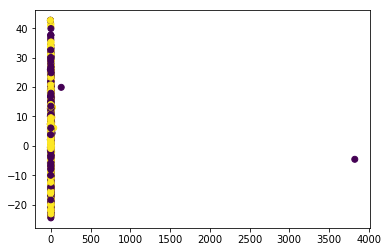

In [58]:
import matplotlib.pyplot as plt
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c = [int(y) for y in y_train])

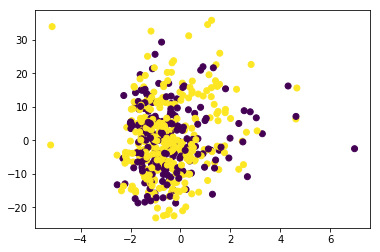

In [59]:
plt.scatter(X_test_pca[:,0],X_test_pca[:,1],c = [int(y) for y in y_test])

#### LDA

In [48]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 2)
X_train_lda = lda.fit_transform(X_train, y_train)

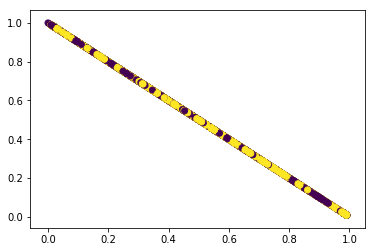

In [49]:
import matplotlib.pyplot as plt
plt.scatter(X_train_lda[:,0],X_train_lda[:,1],c = [int(y) for y in y_train])

### Nerual Network

In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
fake_news = pd.read_csv("fake_news_processed.csv")
from sklearn.model_selection import train_test_split
X = fake_news.loc[:,["score","num_scrap","common_term","crit_term","similar_cnt","url_score"]]
y = fake_news.loc[:,"Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [83]:
# Define Neural Network
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential()
model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

ModuleNotFoundError: No module named 'keras'

In [8]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [9]:
# Training
model.fit(X_train, y_train, epochs=500, batch_size=512)
score = model.evaluate(X_test, y_test, verbose=0)
print('Testing accuracy: %0.4f'%score[1])

Epoch 1/500
9216/9216 [==============================] - 0s 43us/step - loss: 0.9380 - acc: 0.4695
Epoch 2/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.7010 - acc: 0.5591
Epoch 3/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6879 - acc: 0.5605
Epoch 4/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6869 - acc: 0.5607
Epoch 5/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6859 - acc: 0.5609
Epoch 6/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6860 - acc: 0.5609
Epoch 7/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6859 - acc: 0.5609
Epoch 8/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6859 - acc: 0.5609
Epoch 9/500
9216/9216 [==============================] - 0s 7us/step - loss: 0.6859 - acc: 0.5609
Epoch 10/500
9216/9216 [==============================] - 0s 6us/step - loss: 0.6859 - acc: 0.5609
Epoch 11/500
9216/

9216/9216 [==============================] - 0s 4us/step - loss: 0.6807 - acc: 0.5642
Epoch 166/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6804 - acc: 0.5641
Epoch 167/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6809 - acc: 0.5654
Epoch 168/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6806 - acc: 0.5624
Epoch 169/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6814 - acc: 0.5637
Epoch 170/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6813 - acc: 0.5613
Epoch 171/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6806 - acc: 0.5639
Epoch 172/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6806 - acc: 0.5636
Epoch 173/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6805 - acc: 0.5666
Epoch 174/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6817 - acc: 0.5645
Epoch 175/500


9216/9216 [==============================] - 0s 4us/step - loss: 0.6803 - acc: 0.5651
Epoch 248/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6813 - acc: 0.5653
Epoch 249/500
9216/9216 [==============================] - 0s 6us/step - loss: 0.6807 - acc: 0.5615
Epoch 250/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6811 - acc: 0.5615
Epoch 251/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6809 - acc: 0.5632
Epoch 252/500
9216/9216 [==============================] - 0s 6us/step - loss: 0.6806 - acc: 0.5641
Epoch 253/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6805 - acc: 0.5633
Epoch 254/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6806 - acc: 0.5626
Epoch 255/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6812 - acc: 0.5612
Epoch 256/500
9216/9216 [==============================] - 0s 6us/step - loss: 0.6806 - acc: 0.5661
Epoch 257/500


9216/9216 [==============================] - 0s 5us/step - loss: 0.6807 - acc: 0.5638
Epoch 330/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6807 - acc: 0.5623
Epoch 331/500
9216/9216 [==============================] - 0s 6us/step - loss: 0.6811 - acc: 0.5656
Epoch 332/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6815 - acc: 0.5655
Epoch 333/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6811 - acc: 0.5614
Epoch 334/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6806 - acc: 0.5632
Epoch 335/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6803 - acc: 0.5647
Epoch 336/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6803 - acc: 0.5662
Epoch 337/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6819 - acc: 0.5615
Epoch 338/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6826 - acc: 0.5603
Epoch 339/500


9216/9216 [==============================] - 0s 5us/step - loss: 0.6809 - acc: 0.5632
Epoch 412/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6810 - acc: 0.5632
Epoch 413/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6809 - acc: 0.5608
Epoch 414/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6807 - acc: 0.5633
Epoch 415/500
9216/9216 [==============================] - 0s 6us/step - loss: 0.6807 - acc: 0.5633
Epoch 416/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6802 - acc: 0.5646
Epoch 417/500
9216/9216 [==============================] - 0s 6us/step - loss: 0.6813 - acc: 0.5578
Epoch 418/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6827 - acc: 0.5603
Epoch 419/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6821 - acc: 0.5623
Epoch 420/500
9216/9216 [==============================] - 0s 4us/step - loss: 0.6815 - acc: 0.5630
Epoch 421/500


9216/9216 [==============================] - 0s 5us/step - loss: 0.6804 - acc: 0.5633
Epoch 494/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6810 - acc: 0.5638
Epoch 495/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6805 - acc: 0.5633
Epoch 496/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6803 - acc: 0.5646
Epoch 497/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6809 - acc: 0.5627
Epoch 498/500
9216/9216 [==============================] - 0s 6us/step - loss: 0.6804 - acc: 0.5649
Epoch 499/500
9216/9216 [==============================] - 0s 5us/step - loss: 0.6802 - acc: 0.5642
Epoch 500/500
9216/9216 [==============================] - 0s 6us/step - loss: 0.6802 - acc: 0.5635
Testing accuracy: 0.5664


In [10]:
pred = model.predict(X_test)>0.5

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_test, pred)

array([[ 27, 412],
       [ 32, 553]])

In [3]:
27/(27+412)

0.06150341685649203

In [12]:
accuracy_score(y_test, pred)

0.56640625

In [13]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, pred, average = "binary")

(0.5730569948186528, 0.9452991452991453, 0.7135483870967742, None)